# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled Soil and Root Hydraulics, including perirhizal resistance to water flow



In [1]:
import os, sys
sourcedir = os.getcwd()+"/../../../../"
sys.path.append(sourcedir); sys.path.append(sourcedir+"CPlantBox/"); sys.path.append(sourcedir+"CPlantBox/src/")
sys.path.append(sourcedir+"dumux-rosi/python/modules/");
sys.path.append(sourcedir+"dumux-rosi/python/modules/fv/");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/"); 

import plantbox as pb
import visualisation.vtk_plot as vp
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from functional.PlantHydraulicModel import HydraulicModel_Doussan
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from functional.Perirhizal import PerirhizalPython #as Perirhizal
import functional.van_genuchten as vg

from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
import numpy as np
import matplotlib.pyplot as plt
import figure_style
import timeit

In [2]:
def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


""" Parameters """  # |\label{l73c:param}|
min_b = [-35., -10., -50.]  # [cm]
max_b = [35., 10., 0.]  # [cm]
cell_number = [17, 5, 50]  # ~[4*4*1] cm3

path = sourcedir+"CPlantBox/modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
trans = 250  # cm3 /day (sinusoidal) = mL/day
wilting_point = -15000  # cm
rs_age = 21  # root system initial age [day]

loam = [0.078, 0.43, 0.036, 1.56, 24.96]  # hydrus loam
initial = -400  # cm

sim_time = 3.5  # [day]
dt = 360. / (24 * 3600)  # [days]  # |\label{l73c:param_end}|


In [3]:
""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]
s.setHomogeneousIC(initial, True)  # [cm] total potential
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "1000")  
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant()  
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.1)  
plant.setGeometry(sdf) 

""" root hydraulic properties """
params = PlantHydraulicParameters() 
params.read_parameters(sourcedir+"CPlantBox/modelparameter/functional/plant_hydraulics/couvreur2012")
# params.plot_conductivities(True)
hm = HydraulicModel_Doussan(plant, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([x, y, z])  
plant.setSoilGrid(picker)
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # |\label{l73c:rectgrid}|
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test()  

""" Perirhizal initialization """
peri = PerirhizalPython(hm.ms) 
# peri.open_lookup("results/hydrus_loam")  # faster with lookup table
peri.set_soil(vg.Parameters(loam)) # slower without lookup table

outer_r = peri.get_outer_radii("length") 
inner_r = peri.ms.radii
rho_ = np.divide(outer_r, np.array(inner_r)) 

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 8499 nodes for 4250 grid entities in 0.00206554 seconds.
Computed bounding box tree with 8499 nodes for 4250 grid entities in 0.00177403 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 21 days
nodes moved 0
new nodes added 9290
segments added 9290
Number of segments 9291, including 9290 new 
PlantHydraulicModel.test():
9292 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.01190248  0.02370846 -3.49929574]
Node 3 [ 0.01805304  0.05198983 -3.99845738]
Node 4 [ 0.04038416  0.07681955 -4.373614  ]
9291 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different roo

In [ ]:
""" Numerical solution """
start_time = timeit.default_timer()
x_, y_, z_ = [], [], []

hs = s.getSolutionHead_()  # [cm] matric potential 
hs_ = hm.ms.getHs(hs)  # [cm] matric potential per segment  
hsr = hs_.copy()  # initial values for fix point iteration 

N = round(sim_time / dt)
t = 0.

for i in range(0, N): 

    hx = hm.solve(rs_age + t, -trans * sinusoidal(t), hsr, cells = False)  
    hx_old = hx.copy()

    kr_ = hm.params.getKr(rs_age + t) 
    inner_kr_ = np.multiply(inner_r, kr_)  

    err = 1.e6
    c = 0
    while err > 100. and c < 100:  

        """ interpolation """
        hsr = peri.soil_root_interface_potentials(hx[1:], hs_, inner_kr_, rho_)  

        """ xylem matric potential """
        hx = hm.solve_again(rs_age + t, -trans * sinusoidal(t), hsr, cells = False)  
        err = np.linalg.norm(hx - hx_old)
        hx_old = hx.copy()

        c += 1  

    water = s.getWaterVolume()  
    fluxes = hm.radial_fluxes(rs_age + t, hx, hsr, cells = False)  
    s.setSource(hm.sumSegFluxes(fluxes))  # TODO will be moved to MappedSegments 
    s.solve(dt)
    soil_water = (s.getWaterVolume() - water) / dt 

    hs = s.getSolutionHead()  # per cell 
    hs_ = hm.ms.getHs(hs)  # per segment

    x_.append(t) 
    y_.append(hm.get_transpiration(rs_age + t, hx.copy(), hsr.copy()))  # [cm3/day]
    z_.append(soil_water)  # [cm3/day] 

    n = round(float(i) / float(N) * 100.) 
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], {:g} iterations, soil hs [{:g}, {:g}], interface [{:g}, {:g}] cm, root [{:g}, {:g}] cm, {:g} days"
          .format(c, np.min(hs), np.max(hs), np.min(hsr), np.max(hsr), np.min(hx), np.max(hx), s.simTime))

#    if i % 10 == 0:  
#        vp.write_soil("results/example73_{:06d}".format(i // 10), s, min_b, max_b, cell_number)
#        vp.write_plant("results/example73_{:06d}".format(i // 10), hm.ms.plant())  

    t += dt

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")  

/home/daniel/workspace/DUMUX/CPlantBox/tutorial/jupyter/summer_school_2025/../../../../CPlantBox/src/functional/Perirhizal.py:86: RuntimeWarning: invalid value encountered in scalar divide
  k_soilfun = lambda hsoil, hint: (vg.fast_mfp[sp](hsoil) - vg.fast_mfp[sp](hint)) / (hsoil - hint)  # Vanderborgth et al. 2023, Eqn [7]


 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
[                                                                                                    ], 1 iterations, soil hs [-424.5, -375.5], interface [-424.5, -392.5] cm, root [-425.065, -392.723] cm, 0.00416667 days
[                                                                                                    ], 1 iterations, soil hs [-424.5, -375.5], interface [-424.5, -392.5] cm, root [-427.815, -393.012] cm, 0.00833333 days
[                                                                                                    ], 1 iterations, soil hs [-424.501, -375.5], interface [-424.5, -392.5] cm, root [-436.06, -393.881] cm, 0.0125 days
[                                                                                          

[****                                                                                                ], 2 iterations, soil hs [-686.648, -375.5], interface [-659.22, -392.725] cm, root [-3740.71, -597.556] cm, 0.154167 days
[****                                                                                                ], 2 iterations, soil hs [-717.207, -375.5], interface [-686.648, -392.745] cm, root [-3913.58, -608.434] cm, 0.158333 days
[*****                                                                                               ], 2 iterations, soil hs [-751.324, -375.5], interface [-717.207, -392.765] cm, root [-4089.73, -619.55] cm, 0.1625 days
[*****                                                                                               ], 2 iterations, soil hs [-789.499, -375.5], interface [-751.324, -392.787] cm, root [-4269.13, -630.901] cm, 0.166667 days
[*****                                                                                               ], 

[*********                                                                                           ], 2 iterations, soil hs [-9164.37, -375.5], interface [-8862.01, -394.28] cm, root [-11904.1, -1151.22] cm, 0.308333 days
[*********                                                                                           ], 2 iterations, soil hs [-9460.32, -375.5], interface [-9164.37, -394.35] cm, root [-12141.8, -1168.77] cm, 0.3125 days
[*********                                                                                           ], 2 iterations, soil hs [-9749.23, -375.5], interface [-9460.32, -394.421] cm, root [-12375.1, -1186.12] cm, 0.316667 days
[*********                                                                                           ], 2 iterations, soil hs [-10031.5, -375.5], interface [-9749.23, -394.493] cm, root [-12604, -1203.25] cm, 0.320833 days
[*********                                                                                           ], 2 

[*************                                                                                       ], 2 iterations, soil hs [-13747.7, -375.5], interface [-13723.9, -397.401] cm, root [-15000, -1434.16] cm, 0.4625 days
[*************                                                                                       ], 2 iterations, soil hs [-13770.7, -375.5], interface [-13747.7, -397.488] cm, root [-15000, -1436.75] cm, 0.466667 days
[*************                                                                                       ], 2 iterations, soil hs [-13792.8, -375.5], interface [-13770.7, -397.575] cm, root [-15000, -1439.4] cm, 0.470833 days
[*************                                                                                       ], 2 iterations, soil hs [-13814.1, -375.5], interface [-13792.8, -397.623] cm, root [-15000, -1442.04] cm, 0.475 days
[**************                                                                                      ], 2 iteratio

[******************                                                                                  ], 2 iterations, soil hs [-14208.6, -375.5], interface [-14201.5, -399.018] cm, root [-15000, -1528.74] cm, 0.616667 days
[******************                                                                                  ], 2 iterations, soil hs [-14215.6, -375.5], interface [-14208.6, -399.064] cm, root [-15000, -1531.86] cm, 0.620833 days
[******************                                                                                  ], 2 iterations, soil hs [-14222.6, -375.5], interface [-14215.6, -399.11] cm, root [-15000, -1534.96] cm, 0.625 days
[******************                                                                                  ], 2 iterations, soil hs [-14229.4, -375.5], interface [-14222.6, -399.156] cm, root [-15000, -1538.04] cm, 0.629167 days
[******************                                                                                  ], 2 iterat

[**********************                                                                              ], 2 iterations, soil hs [-11385.1, -375.5], interface [-11571.2, -400.824] cm, root [-11419.4, -1333.33] cm, 0.770833 days
[**********************                                                                              ], 2 iterations, soil hs [-11197.9, -375.5], interface [-11385.1, -400.869] cm, root [-11182.2, -1315.85] cm, 0.775 days
[**********************                                                                              ], 2 iterations, soil hs [-11064.6, -375.5], interface [-11197.9, -400.914] cm, root [-10944.4, -1298.23] cm, 0.779167 days
[**********************                                                                              ], 2 iterations, soil hs [-10943.4, -375.5], interface [-11064.6, -400.958] cm, root [-10706.1, -1280.5] cm, 0.783333 days
[**********************                                                                              ], 

[**************************                                                                          ], 2 iterations, soil hs [-6451.27, -375.5], interface [-6559.08, -402.275] cm, root [-5128.86, -743.239] cm, 0.925 days
[**************************                                                                          ], 2 iterations, soil hs [-6345.83, -375.5], interface [-6451.27, -402.311] cm, root [-5027.17, -732.295] cm, 0.929167 days
[***************************                                                                         ], 2 iterations, soil hs [-6242.78, -375.5], interface [-6345.83, -402.346] cm, root [-4928.38, -721.777] cm, 0.933333 days
[***************************                                                                         ], 2 iterations, soil hs [-6142.14, -375.5], interface [-6242.78, -402.381] cm, root [-4832.53, -711.696] cm, 0.9375 days
[***************************                                                                         ], 2

[*******************************                                                                     ], 2 iterations, soil hs [-4081.57, -375.5], interface [-4107.37, -403.55] cm, root [-3471.56, -673.603] cm, 1.07917 days
[*******************************                                                                     ], 2 iterations, soil hs [-4057.74, -375.5], interface [-4081.57, -403.559] cm, root [-3487.49, -682.067] cm, 1.08333 days
[*******************************                                                                     ], 2 iterations, soil hs [-4035.9, -375.5], interface [-4057.74, -403.569] cm, root [-3506.53, -691.085] cm, 1.0875 days
[*******************************                                                                     ], 2 iterations, soil hs [-4016.05, -375.5], interface [-4035.9, -403.58] cm, root [-3528.67, -700.655] cm, 1.09167 days
[*******************************                                                                     ], 2 ite

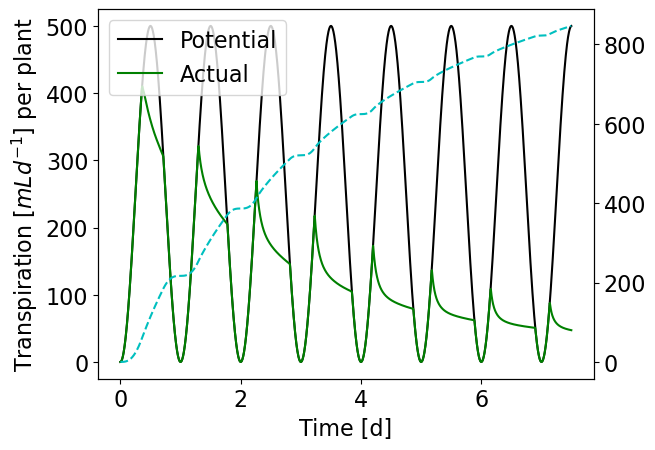

In [21]:
""" VTK visualisation """ 
# vp.plot_roots_and_soil(hm.ms.mappedSegments(), "pressure head", hx, s, True, np.array(min_b), np.array(max_b), cell_number, name)

""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration (neumann)
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiration (neumann)
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
# np.save("results/" + name + "_fp", np.vstack((x_, -np.array(y_), np.array(z_))))  
plt.show()

With the following code snipet, a 4D look-up table is created that speeds up the computation, since all matric potentials at the soil root interface $h_{sr}$ are tabularized for: xylem matric potentials $h_x$ [cm], bulk soil matric potentials, $h_{bs}$ [cm], root radius times hydraulic conductivity [cm/day] , and the geometry factor $\rho$ [1] (outer radius / inner radius). The lookup table takes around 500MB and several to compute.  

In [ ]:
peri = PerirhizalPython()  
hydrus_loam = [0.078, 0.43, 0.036, 1.56, 24.96]  
filename = "hydrus_loam"
sp = vg.Parameters(hydrus_loam)  
vg.create_mfp_lookup(sp) 
peri.create_lookup_mpi("results/" + filename, sp)  